In [2]:
%%capture
%pip install -r ./requirements.txt

In [33]:
import os
import re
from dotenv import load_dotenv
from ibm_watson_machine_learning.foundation_models import Model
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as MetaNames
from langgraph.graph import StateGraph, START, END, MessagesState
from typing import TypedDict

In [2]:
#!pip install --upgrade pip
!pip install langchain-ibm

  Using cached langchain_ibm-0.3.8-py3-none-any.whl.metadata (5.2 kB)
  Using cached ibm_watsonx_ai-1.3.1-py3-none-any.whl.metadata (6.5 kB)
Using cached langchain_ibm-0.3.8-py3-none-any.whl (27 kB)
Using cached ibm_watsonx_ai-1.3.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: ibm-watsonx-ai
    Found existing installation: ibm-watsonx-ai 0.0.5
    Uninstalling ibm-watsonx-ai-0.0.5:
      Successfully uninstalled ibm-watsonx-ai-0.0.5


In [43]:
from langchain_ibm import ChatWatsonx

load_dotenv()
model_id = "ibm/granite-34b-code-instruct"
credentials = {
    "apikey": os.getenv("WATSONX_API_KEY"),
    "url": "https://us-south.ml.cloud.ibm.com"
}

model = ChatWatsonx(
    model_id=model_id,
    apikey=os.getenv("WATSONX_API_KEY"),
    url= "https://us-south.ml.cloud.ibm.com",
    project_id=os.getenv("WATSONX_PROJECT_ID")
)

In [ ]:
import getpass
import os
from langchain_ibm import WatsonxEmbeddings

embeddings = WatsonxEmbeddings(
    model_id="ibm/slate-125m-english-rtrvr",
    apikey=os.getenv("WATSONX_API_KEY"),
    url="https://us-south.ml.cloud.ibm.com",
    project_id=os.getenv("WATSONX_PROJECT_ID")
)

In [ ]:
!pip install faiss-cpu

In [10]:
%%capture
!pip install -qU langchain-community



In [11]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

embedding_dim = len(embeddings.embed_query("hello world"))
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

# Leemos los PDFs con langchain

In [17]:
%%capture
!pip install Pillow



In [ ]:
%%capture
!pip install pypdf

In [20]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders.pdf import PyPDFLoader
import traceback

def safe_pdf_loader(file_path, extract_images=False):
    """
    Safely load PDF documents with optional image extraction
    
    Args:
        file_path (str): Path to the PDF file
        extract_images (bool): Whether to extract images (default: False)
    
    Returns:
        list: Loaded document pages
    """
    try:
        # Disable image extraction to avoid processing issues
        loader = PyPDFLoader(
            file_path=file_path,
            extract_images=extract_images
        )
        
        docs = list(loader.lazy_load())
        
        if docs:
            print(f"Loaded {len(docs)} pages from {file_path}")
            print("First page content preview:", docs[0].page_content[:200])
        
        return docs
    
    except Exception as e:
        print(f"Error loading PDF {file_path}: {e}")
        traceback.print_exc()
        return []

# List of PDF files to load
pdf_files = [
    "hoja_infor_sol_extraccion_aridos.pdf",
    "12informediagnostico_esp_tcm30-543628.pdf", 
    "BOE-A-2024-21701.pdf"
]

# Load PDFs
all_docs = []
for pdf_file in pdf_files:
    docs = safe_pdf_loader(pdf_file, extract_images=False)
    all_docs.extend(docs)

Loaded 7 pages from hoja_infor_sol_extraccion_aridos.pdf
First page content preview: MINISTERIO 
PAR A LA  TRANSICIÓN ECOLÓGICA
CONFEDERACIÓN  
HIDROGRÁFICA DEL 
CANTÁBRICO, O.A. 
COMISARÍA DE AGUAS 
HOJA INFORMATIVA PARA CUMPLIMENTAR LA SOLICITUD DE 
AUTORIZACIÓN PARA LA EXTRACCIÓN D
Loaded 102 pages from 12informediagnostico_esp_tcm30-543628.pdf
First page content preview: Guía para las decisiones 
estratégicas sobre la 
colaboración público-privada en 
la gestión de las plantas de aguas 
residuales 
 
 
Diagnóstico de políticas en el tratamiento de aguas 
residuales a 
Loaded 52 pages from BOE-A-2024-21701.pdf
First page content preview: I. DISPOSICIONES GENERALES
MINISTERIO DE LA PRESIDENCIA, JUSTICIA
Y RELACIONES CON LAS CORTES
21701 Real Decreto 1085/2024, de 22 de octubre, por el que se aprueba el 
Reglamento de reutilización del 


In [21]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 231 sub-documents.


In [22]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['020743bf-dd0f-4de1-90a3-12fc1e5ef803', 'fa221b73-be50-4fe5-b29d-2de6612cc57e', 'c4a1ce2f-9662-4ff8-b257-9da68b52ba82']


In [23]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

c:\Users\ilias\OneDrive\Documentos\UNIVERSIDAD\SEGUNDO AÑO\IBM_Challenge_ODS6\.venv\lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


# Creamos el reatrive context

In [36]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}

In [37]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

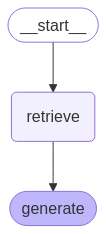

In [38]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
result = graph.invoke({"question": "Que dice el Real Decreto-ley 4/2023?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='9921f079-0ec7-4c30-8d65-8928160fc5dd', metadata={'producer': 'Antenna House PDF Output Library 6.6.1477 (Linux64)', 'creator': 'eBOE', 'creationdate': '2024-10-22T18:21:25+01:00', 'keywords': 'DECRETO 1085/2024 de 22/10/2024;"MINISTERIO DE LA PRESIDENCIA, JUSTICIA Y RELACIONES CON LAS CORTES";BOE-A-2024-21701;BOE 256 de 2024;21701;23/10/2024', 'moddate': '2024-10-22T18:44:21+02:00', 'trapped': '/False', 'subject': 'BOE-A-2024-21701', 'author': 'MINISTERIO DE LA PRESIDENCIA, JUSTICIA Y RELACIONES CON LAS CORTES', 'title': 'Disposición 21701 del BOE núm. 256 de 2024', 'source': 'BOE-A-2024-21701.pdf', 'total_pages': 52, 'page': 15, 'page_label': '16', 'start_index': 812}, page_content='cambios que se produzcan en la normativa de la Unión Europea o, en su caso, cuando lo \naconsejen los cambios en las circunstancias medioambientales o los avances científicos \no tecnológicos.\nDisposición final quinta.\u2003Entrada en vigor.\nEl presente real decreto entrará en vigo